In [1]:
# Installing the required libraries
!pip install prophet
!pip install yfinance

In [2]:
# Mandatory imports

import pandas as pd
import yfinance as yf
from prophet import Prophet
from datetime import datetime
from datetime import timedelta
import plotly.graph_objs as go
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt

In [3]:
# Downloading the bitcoin data using the YFinance library in US Dollars

end_date = datetime.today().strftime('%Y-%m-%d')

data = yf.download(tickers='BTC-USD', start='2014-01-01', end=end_date, interval = '1d')
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

[*********************100%***********************]  1 of 1 completed


In [4]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3203,2023-06-25,30545.150391,31041.271484,30327.943359,30480.261719,30480.261719,12703464114
3204,2023-06-26,30480.523438,30636.029297,29955.744141,30271.130859,30271.130859,16493186997
3205,2023-06-27,30274.320312,31006.787109,30236.650391,30688.164062,30688.164062,16428827944
3206,2023-06-28,30696.560547,30703.279297,29921.822266,30086.246094,30086.246094,14571500779


In [5]:
# Checking the columns of the data

data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
# Summary of the data

data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3.208000e+03
mean,13560.037494,13892.742492,13196.048161,13568.024937,13568.024937,1.658284e+10
std,16012.698364,16415.098988,15553.282405,16010.588285,16010.588285,1.954604e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,751.810013,762.631744,738.415512,751.608276,751.608276,1.263905e+08
50%,7609.135010,7773.959961,7457.438965,7623.104980,7623.104980,1.000702e+10
75%,20060.932617,20380.781738,19636.754883,20097.898926,20097.898926,2.754272e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [7]:
# Checking for data types

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3208 entries, 0 to 3207
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3208 non-null   datetime64[ns]
 1   Open       3208 non-null   float64       
 2   High       3208 non-null   float64       
 3   Low        3208 non-null   float64       
 4   Close      3208 non-null   float64       
 5   Adj Close  3208 non-null   float64       
 6   Volume     3208 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 175.6 KB


In [8]:
# Checking for null values

data.isnull().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [9]:
# Checking for null values

data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
# Since there are no null values we are good to go for buidling the model.
# Extracting required columns

df = data[["Date", "Open"]]

In [11]:
df.head()

,Date,Open
0,2014-09-17,465.864014
1,2014-09-18,456.859985
2,2014-09-19,424.102997
3,2014-09-20,394.673004
4,2014-09-21,408.084991


In [12]:
# Formatting data as required by prophet model

new_names = {
    "Date" : "ds",
    "Open" : "y"
}

df.rename(columns = new_names, inplace=True)

<ipython-input-12-f17ef9ac33bd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = new_names, inplace=True)


In [13]:
# Viewing the first five rows

df.head()

,ds,y
0,2014-09-17,465.864014
1,2014-09-18,456.859985
2,2014-09-19,424.102997
3,2014-09-20,394.673004
4,2014-09-21,408.084991


In [14]:
# Creating a bitcoin prediction graph using the prophet library
x = df["ds"]
y = df["y"]

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y))

# Set title
fig.update_layout(title_text="Time Series Analysis plot of Bitcoin Open Price")

fig.update_layout(
    xaxis=dict(
        rangeselector = dict(
            buttons=list(
                [
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider = dict(visible=True),
        type="date",
    )
)

In [15]:
# Using Prophet pre-trained model

model = Prophet(seasonality_mode="multiplicative", n_changepoints=10)

In [16]:
# Fitting the model

model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnx3zkgcr/r58b6bnj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnx3zkgcr/5laycpzz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52838', 'data', 'file=/tmp/tmpnx3zkgcr/r58b6bnj.json', 'init=/tmp/tmpnx3zkgcr/5laycpzz.json', 'output', 'file=/tmp/tmpnx3zkgcr/prophet_modelrx5f_wcq/prophet_model-20230630114253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:42:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:42:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [17]:
model.component_modes

{'additive': ['additive_terms', 'extra_regressors_additive'],
 'multiplicative': ['yearly',
  'weekly',
  'multiplicative_terms',
  'extra_regressors_multiplicative',
  'holidays']}

In [18]:
# Setting the period for future predictions

future = model.make_future_dataframe(periods = 90)
future.tail()

,ds
3293,2023-09-23
3294,2023-09-24
3295,2023-09-25
3296,2023-09-26
3297,2023-09-27


In [19]:
# Creating future prediction

pred = model.predict(future)
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2014-09-17,219.628504,-6315.917441,6154.852386,219.628504,219.628504,-0.185514,-0.185514,-0.185514,0.000071,0.000071,0.000071,-0.185585,-0.185585,-0.185585,0.0,0.0,0.0,178.884449
1,2014-09-18,219.793974,-5716.581682,5765.282306,219.793974,219.793974,-0.186872,-0.186872,-0.186872,0.002905,0.002905,0.002905,-0.189778,-0.189778,-0.189778,0.0,0.0,0.0,178.720565
2,2014-09-19,219.959443,-5321.781138,5956.803352,219.959443,219.959443,-0.195540,-0.195540,-0.195540,-0.002077,-0.002077,-0.002077,-0.193463,-0.193463,-0.193463,0.0,0.0,0.0,176.948509
3,2014-09-20,220.124912,-6092.851589,6196.126279,220.124912,220.124912,-0.198223,-0.198223,-0.198223,-0.001658,-0.001658,-0.001658,-0.196565,-0.196565,-0.196565,0.0,0.0,0.0,176.491033
4,2014-09-21,220.290381,-5788.045531,6546.199697,220.290381,220.290381,-0.199588,-0.199588,-0.199588,-0.000577,-0.000577,-0.000577,-0.199011,-0.199011,-0.199011,0.0,0.0,0.0,176.323059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3293,2023-09-23,7813.966760,258.763832,12471.253320,7629.319740,7977.308885,-0.203165,-0.203165,-0.203165,-0.001658,-0.001658,-0.001658,-0.201507,-0.201507,-0.201507,0.0,0.0,0.0,6226.445387
3294,2023-09-24,7755.511375,-100.545214,12597.172509,7540.120579,7923.328773,-0.202387,-0.202387,-0.202387,-0.000577,-0.000577,-0.000577,-0.201810,-0.201810,-0.201810,0.0,0.0,0.0,6185.897655
3295,2023-09-25,7697.055990,-185.044856,12079.247076,7445.753937,7868.144280,-0.200677,-0.200677,-0.200677,0.000554,0.000554,0.000554,-0.201231,-0.201231,-0.201231,0.0,0.0,0.0,6152.433364
3296,2023-09-26,7638.600604,-6.729410,12384.113819,7376.004396,7812.959786,-0.198947,-0.198947,-0.198947,0.000782,0.000782,0.000782,-0.199729,-0.199729,-0.199729,0.0,0.0,0.0,6118.921900


In [20]:
pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3293,2023-09-23,6226.445387,258.763832,12471.253320
3294,2023-09-24,6185.897655,-100.545214,12597.172509
3295,2023-09-25,6152.433364,-185.044856,12079.247076
3296,2023-09-26,6118.921900,-6.729410,12384.113819
3297,2023-09-27,6085.332028,300.203896,12237.903706


In [21]:
next_day = (datetime.today() + timedelta(days = 1)).strftime('%Y-%m-%d')
pred[pred['ds'] == next_day]['yhat'].item()

9409.69008053493

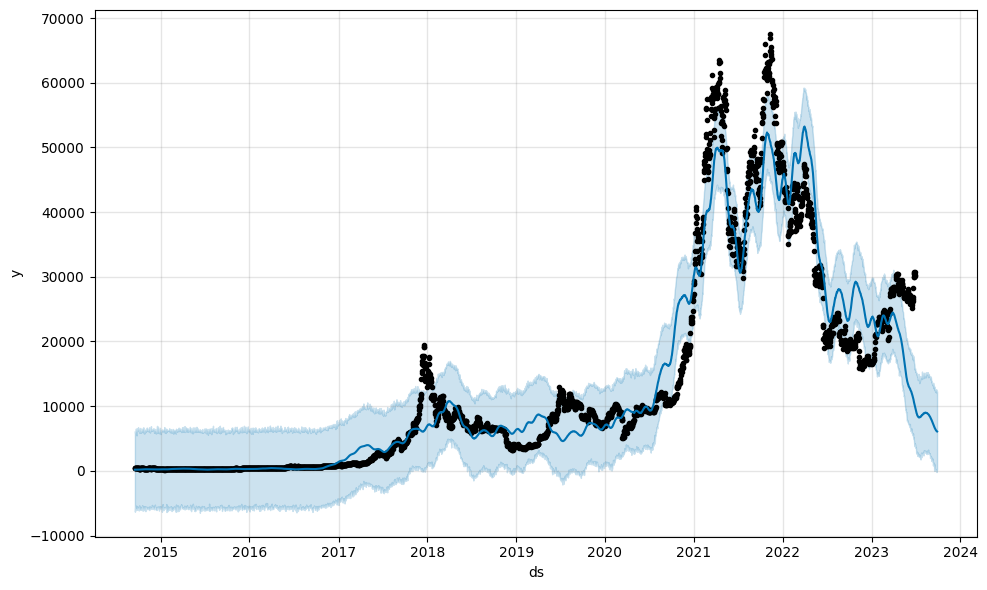

In [22]:
# Plotting the prediction

fig = model.plot(pred)

In [23]:
plot_plotly(model,pred)

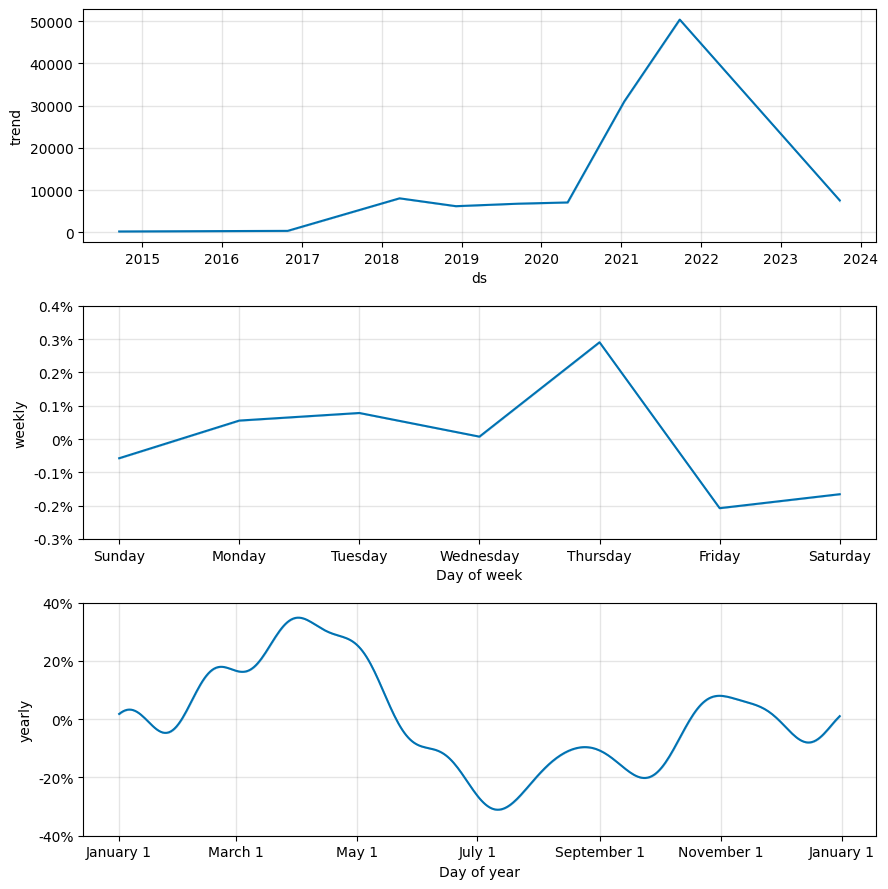

In [24]:
# Plotting the seasonality

fig2 = model.plot_components(pred)

In [25]:
# Default change points
print(f'There are {len(model.changepoints)} change points. \nThe change points dates are \n{df.loc[df["ds"].isin(model.changepoints)]}')

There are 10 change points. 
The change points dates are 
             ds             y
256  2015-05-31    233.134995
513  2016-02-12    379.686005
770  2016-10-26    657.677979
1026 2017-07-09   2572.610107
1282 2018-03-22   8939.440430
1539 2018-12-04   3886.294922
1796 2019-08-18  10233.005859
2052 2020-04-30   8797.669922
2308 2021-01-11  38346.531250
2565 2021-09-25  42840.890625


In [26]:
# Importing pickle to save the model

import pickle
pickle.dump(model, open('crypto.pkl', 'wb'))

In [27]:
# Importing cross validation

from prophet.diagnostics import cross_validation

In [28]:
df_cv=cross_validation(model,horizon='90 days')

INFO:prophet:Making 62 forecasts with cutoffs between 2015-09-24 00:00:00 and 2023-03-31 00:00:00


  0%|          | 0/62 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnx3zkgcr/qui39cx4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnx3zkgcr/fgo6ey08.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98267', 'data', 'file=/tmp/tmpnx3zkgcr/qui39cx4.json', 'init=/tmp/tmpnx3zkgcr/fgo6ey08.json', 'output', 'file=/tmp/tmpnx3zkgcr/prophet_modeln7eg_hjy/prophet_model-20230630114258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnx3zkgcr/r2tqi24_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnx3zkgcr/rf5px9p6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [29]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
5575,2023-06-25,3488.609899,-1084.366097,7961.201650,30545.150391,2023-03-31
5576,2023-06-26,3410.620618,-1277.921668,8247.430721,30480.523438,2023-03-31
5577,2023-06-27,3328.900567,-627.395780,8008.521449,30274.320312,2023-03-31
5578,2023-06-28,3240.741593,-1034.999338,7728.543887,30696.560547,2023-03-31
5579,2023-06-29,3176.536716,-1407.352629,7891.578685,30086.187500,2023-03-31


In [30]:
from prophet.diagnostics import performance_metrics

In [31]:
df_performance = performance_metrics(df_cv)

In [32]:
df_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,1.169372e+08,10813.749726,5440.155838,0.266206,0.151679,0.251002,0.299283
1,10 days,1.278704e+08,11307.978512,5693.439136,0.278145,0.163557,0.261797,0.277778
2,11 days,1.382233e+08,11756.841371,5928.833218,0.288097,0.175145,0.271347,0.270609
3,12 days,1.484499e+08,12184.003450,6160.506677,0.298570,0.180446,0.281460,0.263441
4,13 days,1.591946e+08,12617.235008,6395.371524,0.309849,0.190420,0.292272,0.250896
...,...,...,...,...,...,...,...,...
77,86 days,3.941035e+08,19852.039848,11460.791888,0.622086,0.466113,0.594827,0.132616
78,87 days,3.991221e+08,19978.040074,11552.739563,0.627292,0.467087,0.597767,0.136201
79,88 days,4.041215e+08,20102.773826,11637.874247,0.632526,0.467799,0.600216,0.139785
80,89 days,4.095903e+08,20238.337203,11736.289587,0.638052,0.469378,0.603541,0.143369


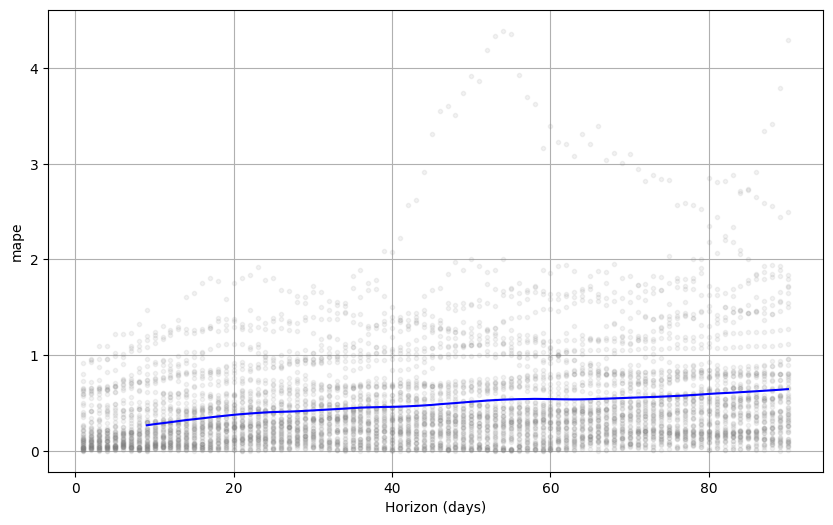

In [33]:
# Plotting cross validation metric
from prophet import plot
fig3 = plot.plot_cross_validation_metric(df_cv,metric='mape')